# Imports

In [187]:
# User-defined functions
# All data preparation functions for GDP data and explanatory variables
from Functions.data_prep import data_GDP, data_explanatory
# Imports for Moran's I analysis and plotting graphs
from Functions.spatial_functions import spatial_weight_matrix, neighborhood_dict_creation, local_moran_density_plot, lisa_cluster_map_STAC1, lisa_update_STAC, quadrant_plot_STAC, local_moran_plots_STAC
# Spatiotemporal outlier analysis
from Functions.spatiotemporal_autocorrelation import year_df_creation, even_time_period_GDP, global_STAC, local_STAC
from Functions.Spatial_outlier_analysis import explanatory_STAC_HL_LH_df_creation, create_interactive_bar_graph, create_categorical_heatmap_HL, country_code_analysis, create_heatmap

# All required imports
from esda.moran import Moran_Local
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

random.seed(21)

# Data preparation

In [188]:
# Data preparation and cleaning for GDP data
# Setting time_period option to all years since this is spatiotemporal analysis and all time periods needed
time_period_option = 'all_years'
NUTS_level = 2
gdf_lvl = data_GDP(NUTS_level, time_period_option)

In [189]:
# Making sure that each region has the same number of time periods which is required for STAC Analysis!
gdf_lvl = even_time_period_GDP(gdf_lvl)

## Spatial weights creation

In [190]:
## Extract only for one year to calculate spatial weight (preventing repeated regions)!!
region_df = year_df_creation(gdf_lvl, 2004)
region_df = region_df.drop(columns=['TIME_PERIOD'])
## Making sure that the index of region is NUTS_ID
region_df.set_index('NUTS_ID', inplace=True)

# Spatial Weights Creation
w_adaptive = spatial_weight_matrix(region_df, 15)
neighbor_weights_dict = neighborhood_dict_creation(w_adaptive)

# Spatiotemporal Autocorrelation Analysis

### Global and Local LISAs

In [191]:
global_STAC_val = global_STAC(neighbor_weights_dict, gdf_lvl, region_df, 'GDP_VALUE')
# p-value calculation
simulated_global_STACs = pd.read_csv("results/simulated_global_STACs.csv")
p_value = np.mean(simulated_global_STACs['0'] >= global_STAC_val)

In [192]:
print("Global STAC value: "+str(global_STAC_val))
print("p-value: "+str(p_value))

Global STAC value: 0.6207243325948555
p-value: 0.0


In [193]:
local_STAC_dict = local_STAC(neighbor_weights_dict, gdf_lvl, region_df, 'GDP_VALUE')

### LISA Calculations

In [194]:
# percentage of lisa values above 0 (positive)
lisa_list = list(local_STAC_dict.values())
count_above_zero = sum(1 for value in lisa_list if value > 0)
total_values = len(lisa_list)
percentage = (count_above_zero / total_values) * 100
percentage

83.15018315018315

In [195]:
# Creating a numpy array of lisa values
lisa_values = np.array(list(local_STAC_dict.values()))
# Creating a lisa object using manually calculated LISA values
lisa = Moran_Local(lisa_values, w_adaptive)
lisa.Is = lisa_values

In [196]:
# Remember to reset index before updating it with LISA values and corresponding significance and quadrant values
region_df.reset_index(inplace=True)

In [197]:
# Updating the dataframe to include local LISA information
variable = "GDP_VALUE"
lisa_results = lisa_update_STAC(region_df, gdf_lvl, local_STAC_dict, w_adaptive, variable)
# Extracting the results
region_df = lisa_results[0]
quadrant_df = lisa_results[1]

#### Extracting significant LISA df from results folder (since permutation calculation takes a while so it is pre-calculated)

In [198]:
region_sig_df = pd.read_csv("results/STAC_LISA_df.csv")
# Extracting p-values and significance column
region_df = region_df.copy()
LISA_df = region_df.copy()
region_df['LISA_p_values'] = region_sig_df['LISA_p_values']
region_df['LISA_sig'] = region_sig_df['LISA_significant']
LISA_df['LISA_p_values'] = region_sig_df['LISA_p_values']
LISA_df['LISA_sig'] = region_sig_df['LISA_significant']

### LISA plots

Plotting the quadrant information to visualize the logic of how each region is classified into each quadrant.

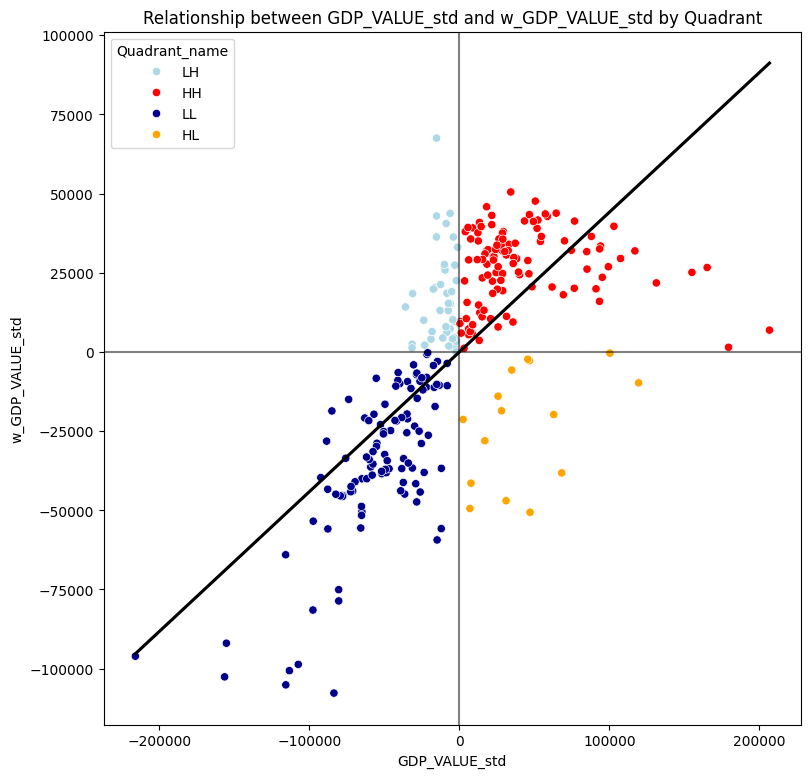

In [199]:
variable = 'GDP_VALUE'
quadrant_plot_STAC(quadrant_df, variable)

Density plot displaying the frequency of positive LISA values is the highest

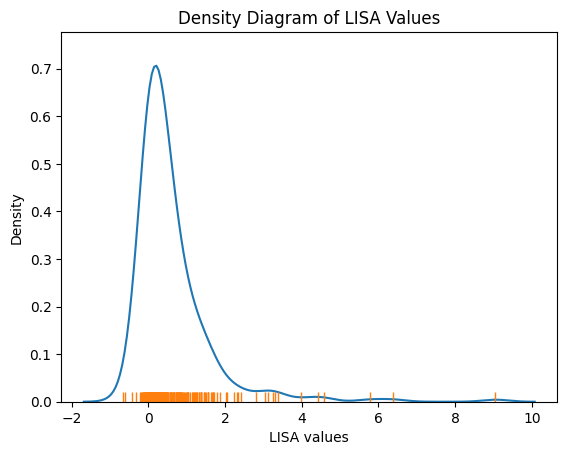

In [200]:
local_moran_density_plot(lisa)

Plotting the LISA values of each region as well as the quadrant information (clusters and outliers) side by side

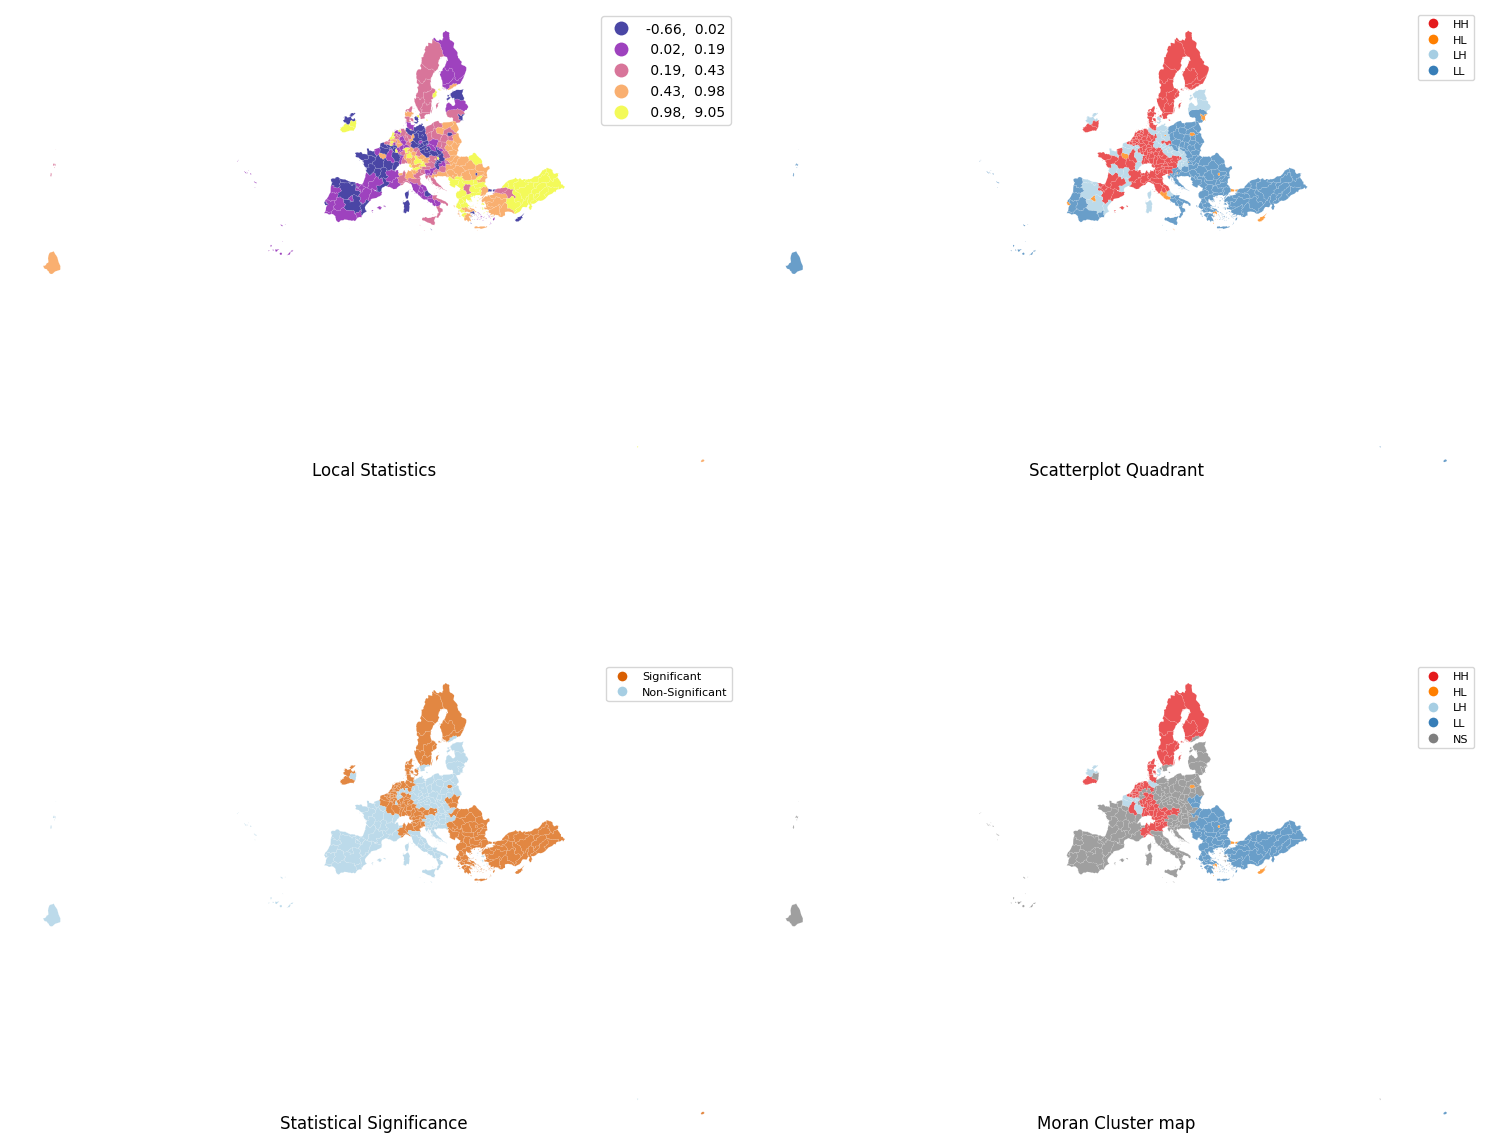

In [201]:
local_moran_plots_STAC(region_df, lisa)

Plotting the LISA Quadrants Map alone to get a better look into the spatial clusters (HH and LL regions) and the spatial outliers (LH and HL regions)

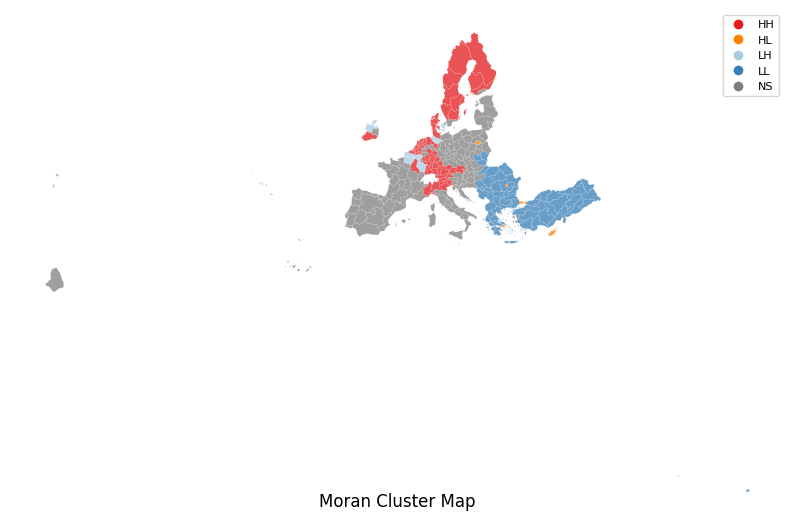

In [202]:
lisa_cluster_map_STAC1(region_df)

# Spatial Outlier Analysis

### Explanatory data loading

In [203]:
exp_data = data_explanatory(False, 'all_years')
# Explanatory df
X_df = exp_data[0]
X_df = X_df.dropna()
# Explanatory variables list
exp_var_list = exp_data[1]
# list of NUTS regions where explanatory variables have values
exp_regions = list(X_df['NUTS_ID'].unique())

#### Data cleaning to ensure equal time period lengths

In [204]:
# Define the list of required years
required_years = set(range(2015, 2020))
# Find NUTS_IDs with complete years
def has_all_years(group):
    return required_years.issubset(group['TIME_PERIOD'].unique())
# Filter NUTS_IDs
valid_nuts_ids = X_df.groupby('NUTS_ID').filter(has_all_years)['NUTS_ID'].unique()
# Convert to list if needed
valid_nuts_ids_list = valid_nuts_ids.tolist()
X_df = X_df[X_df['NUTS_ID'].isin(valid_nuts_ids_list)]

# Filter out final df with years 2015 to 2019:
X_df = X_df[(X_df['TIME_PERIOD'] >= 2015) & (X_df['TIME_PERIOD'] <= 2019)]

### GDP High-low & Low-high regions

In [205]:
# Extracting the significant LISA regions
gdf_lvl_outlier = region_df[region_df['LISA_sig']=='Significant']
# Selecting only regions for which explanatory variable value exists
gdf_lvl_analysis = gdf_lvl_outlier[gdf_lvl_outlier['NUTS_ID'].isin(exp_regions)]

# Finally, creating two dataframes for significant LH and HL regions
LH_regions_GDP = gdf_lvl_analysis[gdf_lvl_analysis['LISA_quadrant']==2]
HL_regions_GDP = gdf_lvl_analysis[gdf_lvl_analysis['LISA_quadrant']==4]

### Explanatory Data: High-low & Low-high regions

#### Spatial Weight matrix

In [206]:
# Merging with gdf_lvl to get the geometries of each location
final_df = pd.merge(X_df, gdf_lvl[['NUTS_ID', 'NAME_LATN', 'NUTS_NAME','geometry', 'TIME_PERIOD']], on=['NUTS_ID', 'TIME_PERIOD'], how='left')

In [207]:
# Extract only for one year to calculate spatial weight (preventing repeated regions)!!
region_df = year_df_creation(final_df, 2015)
region_df = region_df.drop(columns=['TIME_PERIOD'])
# Making sure that the index of region is NUTS_ID
region_df.set_index('NUTS_ID', inplace=True)
# Spatial Weights Creation
w_adaptive_exp = spatial_weight_matrix(region_df, 15)
neighbor_weights_dict = neighborhood_dict_creation(w_adaptive_exp)

In [208]:
# Calling the User-defined function to do the STAC analysis on explanatory data
exp_var_list = exp_var_list.drop('POP_DENS_VAL')
# Function is used to do STAC analysis on each explanatory variable and categorize the regions into the four quadrants
exp_results = explanatory_STAC_HL_LH_df_creation(exp_var_list, final_df, region_df, neighbor_weights_dict, w_adaptive_exp)

In [209]:
# Extracting all results
global_moran_dict = exp_results[0]
local_moran_percent_dict = exp_results[1]
local_moran_dict = exp_results[2]
LH_region_dict = exp_results[3]
HL_region_dict = exp_results[4]
HH_region_dict = exp_results[5]
LL_region_dict = exp_results[6]

### Bar chart of explanatory variables

In [210]:
# Creating a list of explanatory variable dictionaries and list of spatial cluster types for input into function
exp_dict_list = [LH_region_dict, HL_region_dict, LL_region_dict, HH_region_dict]
spatial_cluster_list = ['Low-High', 'High-Low', 'Low-Low', 'High-High']

#### Low-High regions

In [211]:
gdp_outlier_type = 'Low-High'
create_interactive_bar_graph(LH_regions_GDP, exp_dict_list, spatial_cluster_list, gdp_outlier_type)
# Important to remember that the total number of LH regions is only 10

#### High-Low regions

In [212]:
gdp_outlier_type = 'High-Low'
create_interactive_bar_graph(HL_regions_GDP, exp_dict_list, spatial_cluster_list, gdp_outlier_type)
# Important to remember that the total number of HL regions is ONLY 4

### Categorical Heatmap of High-Low regions

In [213]:
create_categorical_heatmap_HL(HL_regions_GDP, HL_region_dict)

# Spatial Cluster Analysis

### GDP: High-High & Low-Low regions

In [214]:
# Finally, creating two dataframes for LH and HL regions
HH_regions_GDP = gdf_lvl_analysis[gdf_lvl_analysis['LISA_quadrant']==1]
LL_regions_GDP = gdf_lvl_analysis[gdf_lvl_analysis['LISA_quadrant']==3]

### Explanatory Data: High-high & Low-low regions

In [215]:
# Extracting results from earlier user-defined function results on GDP outlier and cluster information
HH_region_dict = exp_results[5]
LL_region_dict = exp_results[6]

### Low-Low Regions

In [216]:
# Creating a dataframe with percentage of regions within each country code explained by each explanatory variable
LL_exp_result = country_code_analysis(LL_regions_GDP, LL_region_dict)
exp_df_LL= LL_exp_result[0]
unexplained_countries_LL = LL_exp_result[1]

In [217]:
# Reset the index to get broad categories as a column
exp_df_LL.reset_index(inplace=True)

In [218]:
cluster_type = 'Low-Low'
create_heatmap(exp_df_LL, cluster_type)

### High-High Regions

In [219]:
# Creating a dataframe with percentage of regions within each country code explained by each explanatory variable
HH_exp_result = country_code_analysis(HH_regions_GDP, HH_region_dict)
exp_df_HH = HH_exp_result[0]
unexplained_countries_HH = HH_exp_result[1]

In [220]:
# Reset the index to get broad categories as a column
exp_df_HH.reset_index(inplace=True)

In [221]:
cluster_type = 'High-High'
create_heatmap(exp_df_HH, cluster_type)

# STAC v.s. SAC analysis

In [222]:
# Reading NUTS 2 level dataframe
gdf_sac = pd.read_csv("results/SAC_local_NUTS2.csv")
gdf_sac = gdf_sac.drop(columns=['Unnamed: 0'])
original_len = len(gdf_sac)
gdf_sac = gdf_sac[gdf_sac['LISA_sig']=='Significant']
final_len = len(gdf_sac)
print("Percentage of regions lost at NUTS 2 level after Significance test:")
proportion = (original_len-final_len)/original_len
print(proportion*100)

Percentage of regions lost at NUTS 2 level after Significance test:
35.51724137931034


In [223]:
# Renaming NUTS 3 level dataframe
gdf_stac = LISA_df.copy()
original_len = len(gdf_stac)
gdf_stac = gdf_stac[gdf_stac['LISA_sig']=='Significant']
final_len = len(gdf_stac)
print("Percentage of regions lost at NUTS 2 level after Significance test:")
proportion = (original_len-final_len)/original_len
print(proportion*100)

Percentage of regions lost at NUTS 2 level after Significance test:
47.61904761904761


## Proportion of HL,HH,LL, and LH values

In [224]:
# Calculating proportion of each quadrant in both dataframes
# Calculate the proportion of each value
value_counts_sac = gdf_sac['LISA_quadrant'].value_counts(normalize=True)
# Convert to dictionary
proportions_sac = {str(key): value for key, value in value_counts_sac.items()}
print("NUTS 2 level results:")
proportions_sac

NUTS 2 level results:


{'3': 0.45454545454545453,
 '1': 0.44385026737967914,
 '2': 0.058823529411764705,
 '4': 0.0427807486631016}

In [225]:
# Calculate the proportion of each value
value_counts_stac = gdf_stac['LISA_quadrant'].value_counts(normalize=True)
# Convert to dictionary
proportions_stac = {str(key): value for key, value in value_counts_stac.items()}
print("NUTS 3 level results:")
proportions_stac

NUTS 3 level results:


{'1.0': 0.4825174825174825,
 '3.0': 0.4125874125874126,
 '2.0': 0.06993006993006994,
 '4.0': 0.03496503496503497}

## Spatial outlier similarity

In [226]:
# Extracting HL regions
gdf_sac_HL = gdf_sac[gdf_sac['LISA_quadrant']==4]
gdf_stac_HL = gdf_stac[gdf_stac['LISA_quadrant']==4]

In [227]:
# Extracting HL regions
gdf_sac_LH = gdf_sac[gdf_sac['LISA_quadrant']==2]
gdf_stac_LH = gdf_stac[gdf_stac['LISA_quadrant']==2]

# Temporal trend Similarity

In [228]:
HH_regions = list(HH_regions_GDP['NUTS_ID'])

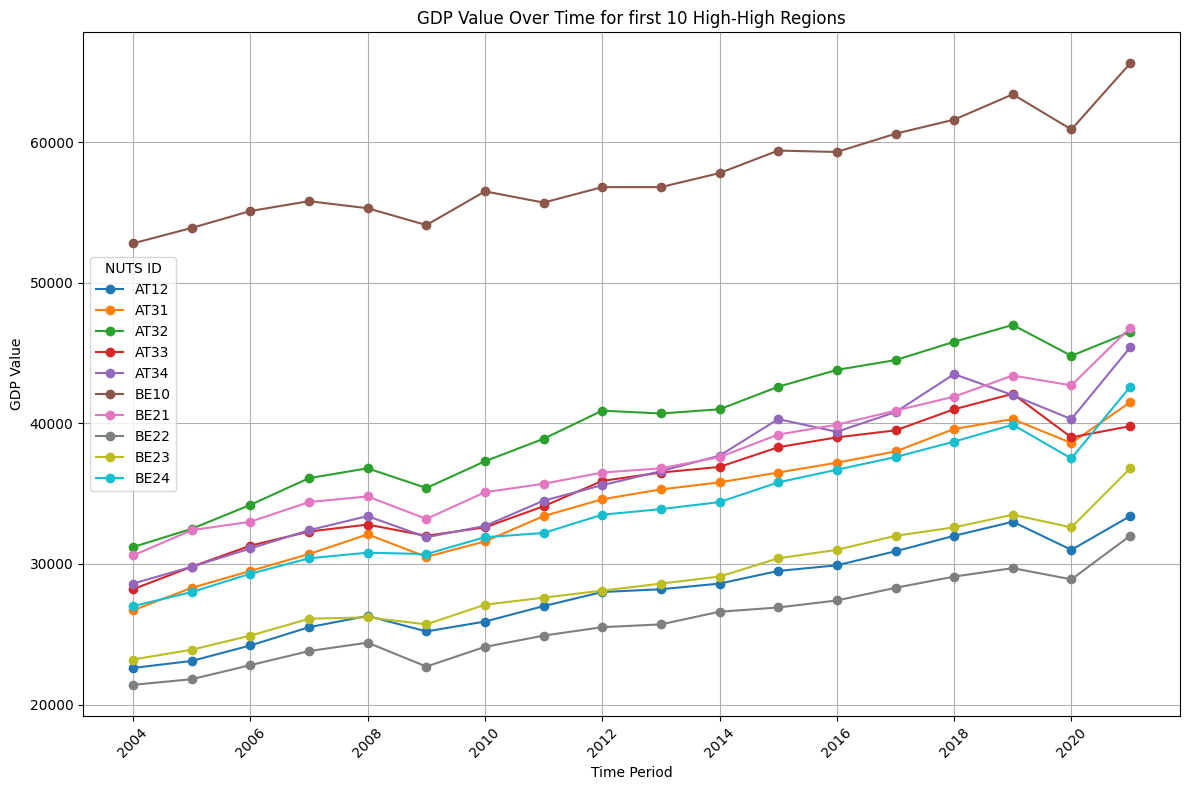

In [229]:
# Convert TIME_PERIOD to datetime
gdf_lvl['TIME_PERIOD'] = pd.to_datetime(gdf_lvl['TIME_PERIOD'], format='%Y')
# Filter the dataframe for LH regions
filtered_gdf_lvl = gdf_lvl[gdf_lvl['NUTS_ID'].isin(HH_regions)]
# Plotting
plt.figure(figsize=(12, 8))
for region in HH_regions[0:10]:
    region_data = filtered_gdf_lvl[filtered_gdf_lvl['NUTS_ID'] == region]
    plt.plot(region_data['TIME_PERIOD'], region_data['GDP_VALUE'], marker='o', linestyle='-', label=region)
plt.xlabel('Time Period')
plt.ylabel('GDP Value')
plt.title('GDP Value Over Time for first 10 High-High Regions')
plt.legend(title='NUTS ID')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()